![](http://docs.astropy.org/en/latest/_images/astropy_banner_96.png)

---

Overview
--------

* Incorporating units into code (not just comments or variable names!)
* Accessing physical constants, with units
* Reading ASCII tables
* Reading FITS files
* Converting astronomical times
* Working with astronomical coordinates

Tutorials:
===========

http://www.astropy.org/astropy-tutorials/


---

### Units

http://docs.astropy.org/en/stable/units/

As astronomers, physicists, and scientists, most of the numerical quantities we use in our code have physical units associated with them. With `astropy.units`, we can now attach those units directly to numerical or arrays of numerical objects in Python.

In [1]:
import astropy.units as u
import numpy as np
15*u.km

<Quantity 15.0 km>

Numbers with an associated unit are `Quantity` objects, and are created by multiplying a number or collection of numbers by a unit object.

In [2]:
[15., 11, 23]*u.km/u.s

<Quantity [ 15., 11., 23.] km / s>

These objects support arbitrary complex unit combinations, and support both common, unambigious abbreviations, and SI prefixes:

In [3]:
print(str('10.*u.km/u.kpc/u.s**2/u.Jansky*u.kiloJoule'))
q = 10.*u.km/u.kpc/u.s**2/u.Jansky*u.kiloJoule
type(q)

10.*u.km/u.kpc/u.s**2/u.Jansky*u.kiloJoule


astropy.units.quantity.Quantity

In [4]:
repr(q)

'<Quantity 10.0 kJ km / (Jy kpc s2)>'

In [5]:
print(q.unit.to_string('latex'))
q

$\mathrm{\frac{kJ\,km}{Jy\,kpc\,s^{2}}}$


<Quantity 10.0 kJ km / (Jy kpc s2)>

And supports unit conversion in a few ways. One use case, is to go from one set of units to an equivalent set of units. An example would be __km/s__ to __mi/hr__ -- the request units are _equivalent_ to the current units:

In [6]:
qq = (17.*u.km/u.s)
qq.to(u.imperial.mile/ u.hour)

<Quantity 38027.916964924836 mi / h>

Another way to convert units is to __decompose__ a `Quantity` into a set of base units. An example would be to decompose ${\rm km/s}$ to the appropriate combination of ${\rm kpc, Myr}$:

In [7]:
q = 151.522*u.km/u.s
q.decompose([u.kpc, u.Myr])

<Quantity 0.1549633926732679 kpc / Myr>

Finally, for basic unit types, you can easily get the value of the quantity in another unit system using dot notation:

In [8]:
q = 11*u.km
q.to(u.femtoparsec)

<Quantity 356.4857218416731 fpc>

In [9]:
q1 = 11.*u.km/u.s
q2 = 12*u.s/u.kpc
q1*q2, (q1*q2).decompose()

(<Quantity 132.0 km / kpc>, <Quantity 4.277828662100078e-15>)

----

### Constants

http://docs.astropy.org/en/stable/constants/

Physical constants are integrated with units 

In [10]:
from astropy.constants import G, M_sun, c
q = (G * M_sun / c**2)
q.to(u.R_sun)

<Quantity 2.1236789989589984e-06 solRad>

In [11]:
q.unit, q.value

(Unit("m"), 1477.035733207975)

In [12]:
# masses of supermassive black holes from 10^5 to 10^9 solar masses
m = np.logspace(5, 9, 10)*u.M_sun
schwarzschild_r = (G * m / c**2)
schwarzschild_r.to(u.au).value # same as schwarzschild_r.au

array([  9.87337404e-04,   2.74732498e-03,   7.64459495e-03,
         2.12715395e-02,   5.91893224e-02,   1.64697805e-01,
         4.58281427e-01,   1.27519529e+00,   3.54830665e+00,
         9.87337404e+00])

---

### ASCII tables

http://docs.astropy.org/en/stable/table/

Data from ___Galactic orbits of RR Lyrae variable stars (Borkova+, 2002)___

File should be in __scicoder_repo/data/borkova2002.tsv__

In [13]:
from astropy.io import ascii
data = ascii.read("borkova2002.tsv")
data[0]

_RAJ2000,_DEJ2000,Name,Simbad,[Fe/H],Theta,Vres,Ra,Zmax,e,_RA,_DE
str8,str8,str8,str6,str5,str4,str4,str4,str4,str5,str8,str8
deg,deg,,,[Sun],km/s,km/s,kpc,kpc,,deg,deg


Notice under the header names, there are two rows of non-data: units, and ---. We can ignore these by specifying the `data_start` keyword:

In [14]:
data = ascii.read("borkova2002.tsv", data_start=3)
data.colnames

['_RAJ2000',
 '_DEJ2000',
 'Name',
 'Simbad',
 '[Fe/H]',
 'Theta',
 'Vres',
 'Ra',
 'Zmax',
 'e',
 '_RA',
 '_DE']

In [15]:
data.rename_column('_RA', 'RA')
data.rename_column('_DE', 'Dec')

In [16]:
ra,dec = data['RA']*u.degree, data['Dec']*u.degree

In [17]:
import matplotlib.pyplot as plt

/Users/imomcheva/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [18]:
%matplotlib inline

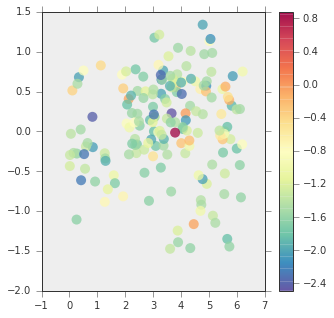

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(ra.to(u.radian).value, 
        dec.to(u.radian).value, 
        c=data['[Fe/H]'], 
        edgecolor='none', 
        cmap='Spectral_r', s=100, alpha=0.75)
plt.colorbar()

Here's a killer feature: writing to a Latex table! Let's say we select out some data from this table that we then want to put into our own Latex document. We can use the `ascii.Latex` writer to do that!

We'll start by selecting a subset of the columns

In [20]:
subset = data['RA', 'Dec', '[Fe/H]', 'Vres']

Now let's select a subset of the data, say only stars between 100 < RA < 200, and Dec > 15:

In [21]:
subset = subset[(subset['RA'] > 100) & 
                (subset['RA'] < 200) & 
                (subset['Dec'] > 15)]
len(subset)

24

Let's rename some columns to make a bit more sense:

In [22]:
subset.rename_column('RA', 'RA [deg]')
subset.rename_column('Dec', 'Dec [deg]')

Now we can write out to a Latex table, and copy-paste into a document!

In [23]:
formats = {"RA [deg]" : "{:.2f}"}
ascii.write(subset, Writer=ascii.Latex, formats=formats)

\begin{table}
\begin{tabular}{cccc}
RA [deg] & Dec [deg] & [Fe/H] & Vres \\
107.90 & 40.777 & -0.8 & 122 \\
139.78 & 29.0655 & -1.52 & 241 \\
121.61 & 23.2516 & -0.07 & 135 \\
126.43 & 25.7191 & -1.89 & 417 \\
192.44 & 43.774 & -1.98 & 245 \\
188.98 & 37.2067 & -2.2 & 279 \\
190.21 & 37.0927 & -1.53 & 259 \\
187.62 & 40.5089 & -2.34 & 394 \\
188.19 & 27.0293 & -2.0 & 185 \\
196.28 & 23.2785 & -1.65 & 163 \\
199.46 & 20.7808 & -1.26 & 264 \\
174.49 & 67.3297 & -1.74 & 325 \\
184.44 & 69.5106 & -1.24 & 118 \\
110.39 & 30.8832 & -0.35 & 57 \\
118.43 & 19.2733 & -1.81 & 376 \\
156.36 & 28.7854 & -1.15 & 278 \\
151.53 & 39.3577 & -1.68 & 285 \\
135.78 & 44.5856 & -1.76 & 309 \\
116.28 & 43.1115 & -1.23 & 62 \\
151.93 & 23.9918 & -1.57 & 130 \\
170.99 & 26.615 & -1.38 & 231 \\
171.55 & 17.661 & -1.71 & 273 \\
172.45 & 30.0673 & -1.44 & 586 \\
182.81 & 47.8288 & -0.72 & 118 \\
\end{tabular}
\end{table}


----

### FITS

http://docs.astropy.org/en/stable/io/fits/

Reading FITS data into Python is easy with the `astropy.io.fits` subpackage.

In [24]:
from astropy.io import fits

In [26]:
hdulist = fits.open("M51.fits")
hdulist.info()

Filename: M51.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     107   (777, 777)   int16   


In [27]:
img_data = hdulist[0].data
img_header = hdulist[0].header

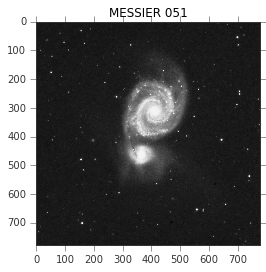

In [31]:
plt.imshow(img_data, cmap='Greys_r')
plt.title(img_header['OBJECT'])

Sometimes you'll need to read in a file, subselect or modify the data, then write it back out. Here's a good recipe for doing that:

In [32]:
hdulist = fits.open("M51.fits")
hdu = hdulist[0] # let's say I want to modify this HDU

hdu.header['OBJECT']

'MESSIER 051'

In [33]:
hdu.header['OBJECT'] = "CAT"
hdu.header['OBJECT']

hdu.data = hdu.data[100:-100, 100:-100] # crop the image data

In [34]:
hdu.writeto("M51_modified.fits", clobber=True)

---

### Time

http://docs.astropy.org/en/stable/time/

For handling astronomical times -- built around SOFA, for handling _very precise_ times.

In [35]:
from astropy.time import Time

In [36]:
img_header['DATE']

'2002-09-16T18:53:16'

In [37]:
time = Time(img_header['DATE'], 
            format='isot', 
            scale='utc')

In [38]:
time.jd, time.mjd

(2452534.286990741, 52533.786990740744)

### Coordinates

http://docs.astropy.org/en/stable/coordinates/

In [41]:
from astropy.coordinates import SkyCoord

In [42]:
eq = SkyCoord(ra=15.1231, dec=-0.141241, 
                           unit=(u.degree, u.degree), frame='icrs')
eq

<SkyCoord (ICRS): (ra, dec) in deg
    (15.1231, -0.141241)>

Can transform to other coordinate systems:

In [44]:
eq.galactic

<SkyCoord (Galactic): (l, b) in deg
    (127.91023558, -62.92543435)>

Formatting coordinates:

In [50]:
gal = eq.galactic
print(gal.l, gal.b)

127d54m36.8481s -62d55m31.5637s


'8:31:38.45654'

In [51]:
gal.l.to_string(sep=":",unit=u.hour, precision=5)

'8:31:38.45654'

In [52]:
"{0} {1}".format(gal.l.to_string(sep=":", unit=u.hour, precision=5), 
                 gal.b.to_string(sep=":", unit=u.degree, precision=3))

'8:31:38.45654 -62:55:31.564'

Some magic:

In [53]:
SkyCoord.from_name("NGC 5466")

<SkyCoord (ICRS): (ra, dec) in deg
    (211.363708, 28.534444)>